In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import paired_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [6]:
df = pd.read_csv('people_wiki.csv')
df.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [7]:
vect = CountVectorizer()
word_weight = vect.fit_transform(df['text'])

In [8]:
nn = NearestNeighbors(metric = 'euclidean')
nn.fit(word_weight)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [10]:
obama_index = df[df['name'] == 'Barack Obama'].index[0]
distances, indices = nn.kneighbors(word_weight[obama_index], n_neighbors = 10)

In [11]:
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})
neighbors

,distance,id
0,0.000000,35817
1,33.015148,24478
2,34.307434,28447
3,35.791060,14754
4,36.069378,35357
5,36.249138,31423
6,36.276714,13229
7,36.400549,36364
8,36.441734,22745
9,36.837481,7660


In [14]:
nearest_info = (df.merge(neighbors, right_on = 'id', left_index = True).
               sort_values('distance')[['id', 'name', 'distance']])
nearest_info

,id,name,distance
0,35817,Barack Obama,0.000000
1,24478,Joe Biden,33.015148
2,28447,George W. Bush,34.307434
3,14754,Mitt Romney,35.791060
4,35357,Lawrence Summers,36.069378
5,31423,Walter Mondale,36.249138
6,13229,Francisco Barrio,36.276714
7,36364,Don Bonker,36.400549
8,22745,Wynn Normington Hugh-Jones,36.441734
9,7660,Refael (Rafi) Benvenisti,36.837481


In [15]:
def unpack_word_weight(vect, word_weight):
    feature_names = np.array(vect.get_feature_names())
    data = word_weight.data
    indptr = word_weight.indptr
    indices = word_weight.indices
    n_docs = word_weight.shape[0]
    
    word_weight_list=[]
    for i in range(n_docs):
        doc = slice(indptr[i], indptr[i+1])
        count, idx = data[doc], indices[doc]
        feature = feature_names[idx]
        word_weight_dict = Counter({k: v for k, v in zip(feature, count)})
        word_weight_list.append(word_weight_dict)
    return word_weight_list

In [19]:
df['word_weight'] = unpack_word_weight(vect, word_weight)

In [16]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [17]:
word_weight

<59071x548429 sparse matrix of type '<class 'numpy.int64'>'
	with 10244028 stored elements in Compressed Sparse Row format>

In [20]:
df.head()

,URI,name,text,word_weight
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'digby': 1, 'morrell': 5, 'born': 1, '10': 1,..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'is': 2, 'with': 2, 'the': 2, 'and': 10, 'in'..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'is': 7, 'who': 1, 'with': 4, 'the': 12, 'and..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'born': 1, 'is': 3, 'with': 3, 'the': 22, 'an..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'born': 1, 'is': 1, 'who': 1, 'with': 2, 'the..."


In [21]:
def get_top_words(df, name, column_name, top_n=None):
    row = df.loc[df['name'] == name, column_name]
    word_weight_dict = row.to_dict()[row.index[0]]
    
    if top_n is None:
        top_n = len(word_weight_dict)
    word_weight_table = pd.DataFrame(word_weight_dict.most_common(top_n),
                                    columns = ['word', 'weight'])
    return word_weight_table

In [24]:
words_obama = get_top_words(df, name='Barack Obama', column_name='word_weight')
words_biden = get_top_words(df, name = 'Joe Biden', column_name = 'word_weight')
words_combined = (words_obama.merge(words_biden, on = 'word').
                 rename(columns={'weight_x': 'Obama', 'weight_y':'Biden'}))
words_combined.head(8)

,word,Obama,Biden
0,the,40,33
1,in,30,16
2,and,21,19
3,of,18,12
4,to,14,11
5,his,11,5
6,obama,9,4
7,act,8,5


In [25]:
def has_top_words(word_weight_vector, common_words):
    unique_words = set(word_weight_vector.keys())
    boolean = common_words.issubset(unique_words)
    return boolean

In [27]:
common_words = set(words_combined['word'].head(5))
print('top 5 common words:', common_words)
df['has_top_words'] = df['word_weight'].apply(has_top_words, args = (common_words,))
print('number of articles that also contain the common words: ', df['has_top_words'].sum())

top 5 common words: {'the', 'to', 'of', 'in', 'and'}
number of articles that also contain the common words:  56066


In [28]:
tfidf_vect = TfidfVectorizer()
tfidf_weight = tfidf_vect.fit_transform(df['text'])

nn_cosine = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
nn_cosine.fit(tfidf_weight)
obama_index = df[df['name'] == 'Barack Obama'].index[0]
cosine, indices = nn_cosine.kneighbors(tfidf_weight[obama_index], n_neighbors = 100)

# 1. flatten the 2d-array distance and indices to 1d
# 2. merge the distance information with the original wiki dataset, 
#    to obtain the name matching the id.
neighbors_cosine = pd.DataFrame({'cosine': cosine.flatten(), 'id': indices.flatten()})
nearest_info = (df.
                merge(neighbors_cosine, right_on = 'id', left_index = True).
                sort_values('cosine')[['id', 'name', 'cosine']])

nearest_info.head()

,id,name,cosine
0,35817,Barack Obama,0.000000
1,24478,Joe Biden,0.570781
2,57108,Hillary Rodham Clinton,0.615934
3,38376,Samantha Power,0.624993
4,38714,Eric Stern (politician),0.649765


In [29]:
df['tfidf_weight'] = unpack_word_weight(tfidf_vect, tfidf_weight)
df.head(3)

,URI,name,text,word_weight,has_top_words,tfidf_weight
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'digby': 1, 'morrell': 5, 'born': 1, '10': 1,...",True,"{'melbourne': 0.04943650649482413, 'college': ..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'is': 2, 'with': 2, 'the': 2, 'and': 10, 'in'...",True,"{'every': 0.03831773682944378, 'capsule': 0.07..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'is': 7, 'who': 1, 'with': 4, 'the': 12, 'and...",True,"{'society': 0.03991955990922275, 'hamilton': 0..."


In [ ]:
words_obama = get_top_words(wiki, name = 'Barack Obama', column_name = 'tfidf_weight')
words_biden = get_top_words(wiki, name = 'Joe Biden', column_name = 'tfidf_weight')

words_combined = (words_obama.
                  merge(words_biden, on = 'word').
                  rename(columns = {'weight_x': 'Obama', 'weight_y': 'Biden'}))
words_combined.head(6)

In [31]:
def compute_length(row):
    return len(row.split(' '))


df['length'] = df['text'].apply(compute_length) 
df.head(3)

,URI,name,text,word_weight,has_top_words,tfidf_weight,length
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'digby': 1, 'morrell': 5, 'born': 1, '10': 1,...",True,"{'melbourne': 0.04943650649482413, 'college': ...",251
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'is': 2, 'with': 2, 'the': 2, 'and': 10, 'in'...",True,"{'every': 0.03831773682944378, 'capsule': 0.07...",223
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'is': 7, 'who': 1, 'with': 4, 'the': 12, 'and...",True,"{'society': 0.03991955990922275, 'hamilton': 0...",226


In [33]:
nearest_cosine = (df.
                  merge(neighbors_cosine, right_on = 'id', left_index = True).
                  sort_values('cosine')[['id', 'name', 'cosine', 'length']])

nearest_cosine.head()

,id,name,cosine,length
0,35817,Barack Obama,0.000000,540
1,24478,Joe Biden,0.570781,414
2,57108,Hillary Rodham Clinton,0.615934,580
3,38376,Samantha Power,0.624993,310
4,38714,Eric Stern (politician),0.649765,255


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


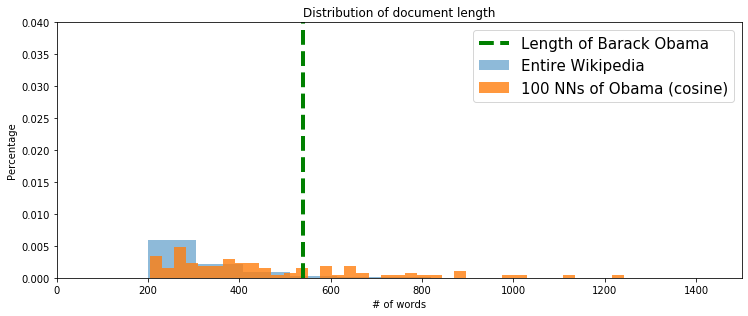

In [35]:
plt.figure(figsize = (10.5, 4.5))
plt.hist(df['length'], 50, histtype = 'stepfilled', 
         normed = True, label = 'Entire Wikipedia', alpha = 0.5)

plt.hist(nearest_cosine['length'], 50, histtype = 'stepfilled', 
         normed = True, label = '100 NNs of Obama (cosine)', alpha = 0.8)

plt.axvline(nearest_cosine.loc[nearest_cosine['name'] == 'Barack Obama', 'length'].values, 
            color = 'g', linestyle = '--', linewidth = 4,
            label = 'Length of Barack Obama')

plt.axis([0, 1500, 0, 0.04])
plt.legend(loc = 'best', prop = {'size': 15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.tight_layout()

In [36]:
tweet = tfidf_vect.transform(['democratic governments control law in response to popular act'])
tweet_dist = paired_distances(tfidf_weight[obama_index], tweet, metric = 'cosine')

# compare to the 100 articles that were nearest to Obama's,
# the distance of this tweet is shorter than how many articles
np.sum(tweet_dist < nearest_cosine['cosine'].values)

79